In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from sqlalchemy import create_engine
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from PIL import Image

In [76]:
engine = create_engine('sqlite:///pba.db')
with engine.connect() as conn:
    df_player = pd.read_sql('SELECT * FROM player', con=conn)
    df_avg_stat = pd.read_sql('SELECT * FROM avg_stat', con=conn)
    df_tot_stat = pd.read_sql('SELECT * FROM total_stat', con=conn)
    df_team = pd.read_sql('SELECT * FROM team', con=conn)
    df_team_avg_stat = pd.read_sql('SELECT * FROM team_avg_stat', con=conn)
    df_team_tot_stat = pd.read_sql('SELECT * FROM team_total_stat', con=conn)
    df_history = pd.read_sql('SELECT * FROM history', con=conn)
    df_conference = pd.read_sql('SELECT * FROM conference', con=conn)
    
engine.dispose()

In [113]:
def get_total_stat():
    """Return all total stat"""
    df_all_total = (pd.merge(df_tot_stat.add_prefix('ply_'),
                        df_team_tot_stat.add_prefix('tm_'), how='left',
                        left_on=['ply_team_id', 'ply_hist_id'],
                         right_on=['tm_team_id', 'tm_hist_id']))
    return df_all_total

def get_average_stat():
    """Return all average stat"""
    df_all_average = (pd.merge(df_avg_stat.add_prefix('ply_'),
                            df_team_avg_stat.add_prefix('tm_'), how='left',
                            left_on=['ply_team_id', 'ply_hist_id'],
                             right_on=['tm_team_id', 'tm_hist_id']))
    return df_all_average

def get_all_stat():
    """Return all stat values"""
    df_all_total = get_total_stat()
    df_all_average = get_average_stat()
    df_all_stat = pd.merge(df_all_average, df_all_total,
                       on=['ply_team_id','ply_hist_id','ply_player_id'],
                       how='inner',
                       suffixes=['_avg', '_total'])
    return df_all_stat

def get_all_data():
    """Return all the data"""
    df_all_stat = get_all_stat()
    all_cols = [col for col in df_all_stat.columns if 'id' not in col]
    all_cols.insert(1, 'year')
    all_cols.insert(2, 'conference')
    all_cols.insert(3, 'player_name')
    all_cols.insert(4, 'team_name')
    df_all_year = pd.merge(df_all_stat, df_history, how='inner',
                       left_on='ply_hist_id', right_on='index')
    df_all_conf = pd.merge(df_all_year, df_conference, how='left',
                           left_on='conference_id', right_on='index')
    df_all_player= pd.merge(df_all_conf, df_player, how='left',
                            left_on='ply_player_id', right_on='index')
    df_all_named= pd.merge(df_all_player, df_team, how='left',
                            left_on='ply_team_id', right_on='index')
    return df_all_named[all_cols]

# Word Cloud Player Frequency

In [12]:
def display_wc_player_freq():
    """Show playername Wordcloud based on minutes"""
    # Get player frequency
    engine = create_engine('sqlite:///pba.db')
    with engine.connect() as conn:
        df_player_total_mins = pd.read_sql("""SELECT p.player_name, ts.`MIN`
                                                FROM player p
                                                INNER JOIN total_stat ts
                                                ON p.`index` = ts.player_id
                                            """,
                                           con=conn)
    engine.dispose()
    df_player_total_mins.MIN = (df_player_total_mins.MIN
                                .apply(lambda x: round(x)))
    df_player_total_mins['last_name'] = (df_player_total_mins.player_name
                                     .apply(lambda x: x.split('. ')[1]))
    player_freq = (df_player_total_mins.groupby('last_name')
               .sum().squeeze().to_dict())
    pba_mask = np.array(Image.open('pba_logo_wc.png'))
    # Word Cloud
    wc = WordCloud(mask=pba_mask, random_state=40, relative_scaling=0, 
                  background_color="white", regexp=r'\b[a-zA-Z]+?\b',
                   repeat=False)

    wc.generate_from_frequencies(player_freq)

    image_colors = ImageColorGenerator(pba_mask)
    wc.recolor(color_func=image_colors)
    plt.figure(figsize=(15, 10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off');

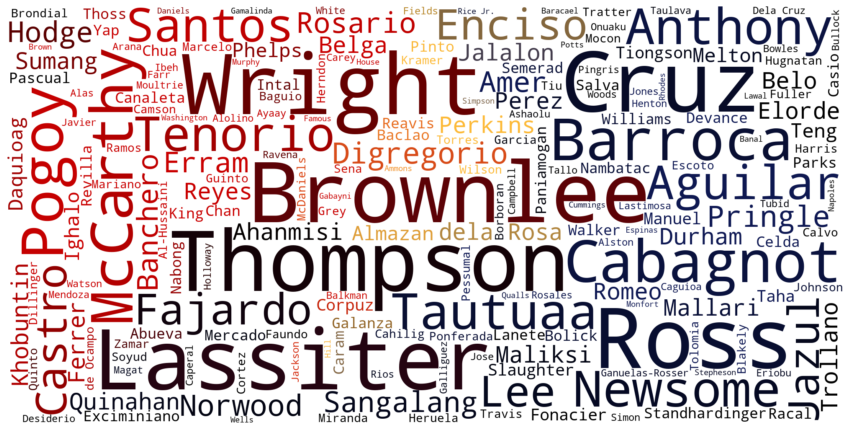

In [13]:
display_wc_player_freq()

# Hierarchical Clustering Team

## Average Team Statistics

In [74]:
feature = df_team_avg_stat.iloc[:, 3:]
targets = df_team_avg_stat.iloc[:, :]

In [75]:
targets

,W,L
0,10,7
1,7,5
2,8,5
3,7,5
4,3,8
...,...,...
81,8,6
82,12,7
83,5,8
84,1,0
